In [3]:
!pip install --upgrade tensorflow
#tensorflow 1.15以上ではないと、hubが使用できない

  Using cached tensorflow-2.4.1-cp38-cp38-macosx_10_11_x86_64.whl (173.9 MB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Using cached tensorboard-2.4.1-py3-none-any.whl (10.6 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [10]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [11]:
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

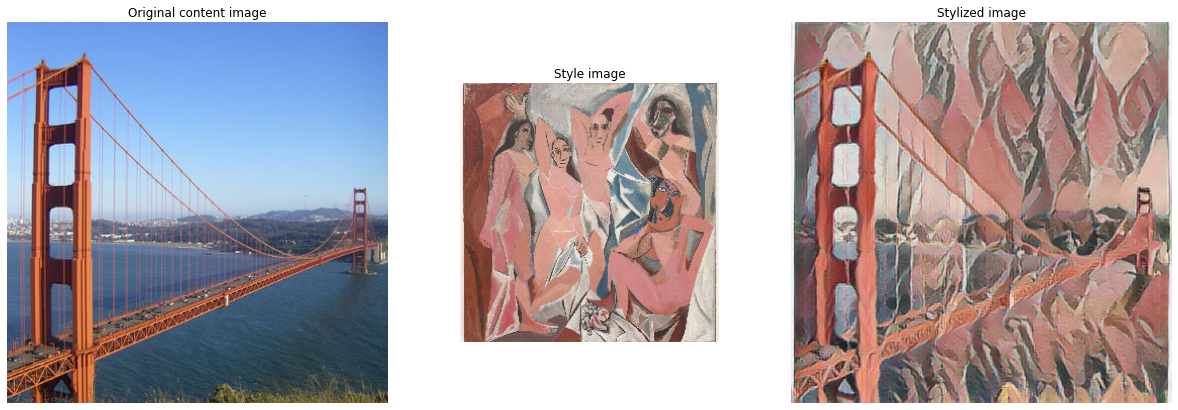

In [12]:
content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
#style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg'
style_img_size = (256, 256)  # Recommended to keep it at 256.
output_image_size = 384
content_img_size = (output_image_size, output_image_size)
content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])